In [ ]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 56.7 MB/s eta 0:00:00


In [ ]:
import zipfile
import os

# Path to your zip file
zip_path = "/content/data/EEG and HF data under stress/EEG and HF data under stress.zip"
extract_dir = "/content/data_set"

# Create folder if not exists
os.makedirs(extract_dir, exist_ok=True)

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Unzipped to:", extract_dir)

Unzipped to: /content/data_set



Fold 1 | Accuracy: 0.7052
              precision    recall  f1-score   support

      Normal       0.78      0.93      0.84       704
  Low-Stress       0.65      0.41      0.50       344
 High-Stress       0.56      0.55      0.56       343

    accuracy                           0.71      1391
   macro avg       0.66      0.63      0.63      1391
weighted avg       0.69      0.71      0.69      1391



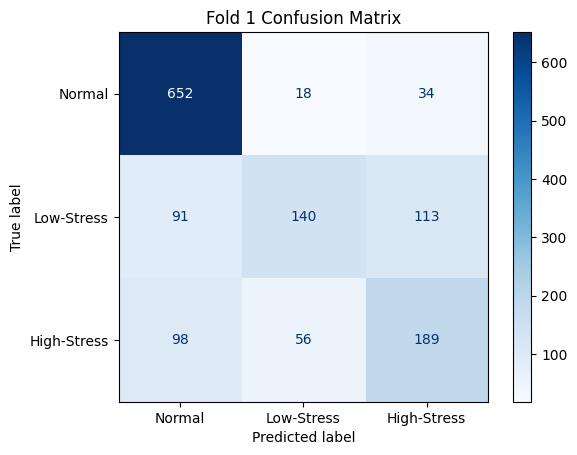

Sample Stress Scores: [np.float32(0.026870053), np.float32(0.10185403), np.float32(0.51307845), np.float32(0.20421758), np.float32(0.041211545), np.float32(0.09064622), np.float32(0.09078635), np.float32(0.15214883), np.float32(0.03666113), np.float32(0.029935498)]
Saved ONNX model for fold 1: ./shallow_cnn_models/shallow_cnn_fold1.onnx

Fold 2 | Accuracy: 0.7088
              precision    recall  f1-score   support

      Normal       0.80      0.92      0.85       703
  Low-Stress       0.62      0.47      0.53       345
 High-Stress       0.56      0.52      0.54       343

    accuracy                           0.71      1391
   macro avg       0.66      0.64      0.64      1391
weighted avg       0.69      0.71      0.70      1391



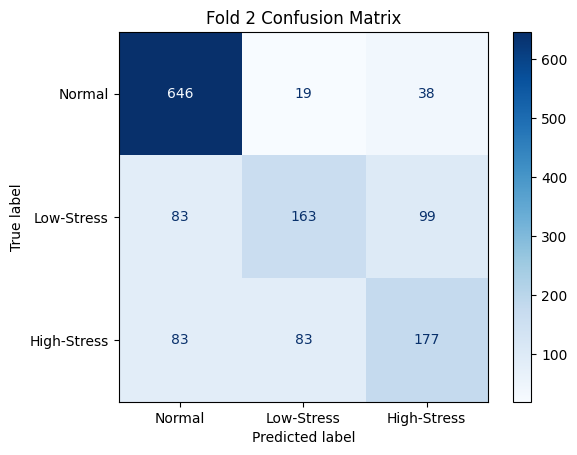

Sample Stress Scores: [np.float32(0.28582007), np.float32(0.10264517), np.float32(0.07093623), np.float32(0.41952485), np.float32(0.22161911), np.float32(0.63534653), np.float32(0.18604629), np.float32(0.20528057), np.float32(0.25937837), np.float32(0.04769901)]
Saved ONNX model for fold 2: ./shallow_cnn_models/shallow_cnn_fold2.onnx

Fold 3 | Accuracy: 0.7115
              precision    recall  f1-score   support

      Normal       0.80      0.94      0.86       703
  Low-Stress       0.59      0.45      0.51       345
 High-Stress       0.58      0.50      0.54       342

    accuracy                           0.71      1390
   macro avg       0.65      0.63      0.64      1390
weighted avg       0.69      0.71      0.70      1390



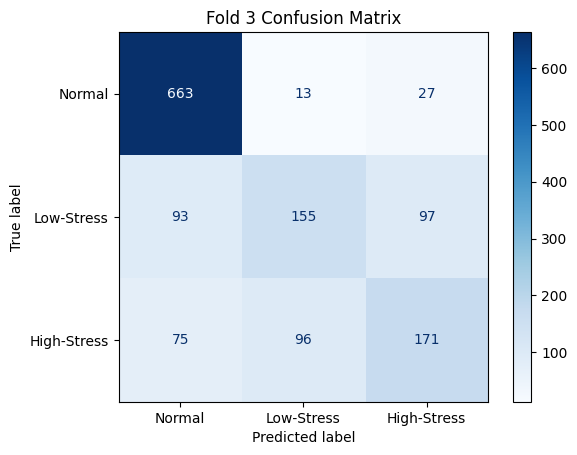

Sample Stress Scores: [np.float32(0.0410046), np.float32(0.015786028), np.float32(0.20657313), np.float32(0.15077552), np.float32(0.29722285), np.float32(0.08678833), np.float32(0.16115205), np.float32(0.020867646), np.float32(0.24145246), np.float32(0.15365791)]
Saved ONNX model for fold 3: ./shallow_cnn_models/shallow_cnn_fold3.onnx

Fold 4 | Accuracy: 0.6849
              precision    recall  f1-score   support

      Normal       0.78      0.92      0.84       703
  Low-Stress       0.59      0.36      0.45       344
 High-Stress       0.52      0.52      0.52       343

    accuracy                           0.68      1390
   macro avg       0.63      0.60      0.60      1390
weighted avg       0.67      0.68      0.67      1390



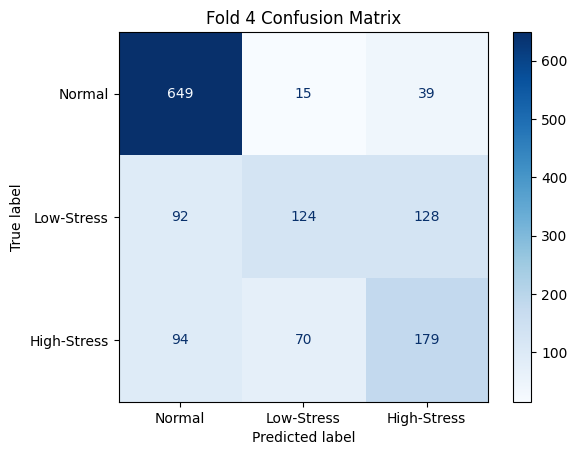

Sample Stress Scores: [np.float32(0.17988306), np.float32(0.503742), np.float32(0.078293964), np.float32(0.37149155), np.float32(0.27149826), np.float32(0.21119276), np.float32(0.029238265), np.float32(0.2131021), np.float32(0.010022272), np.float32(0.004277111)]
Saved ONNX model for fold 4: ./shallow_cnn_models/shallow_cnn_fold4.onnx

Fold 5 | Accuracy: 0.6856
              precision    recall  f1-score   support

      Normal       0.80      0.92      0.85       703
  Low-Stress       0.56      0.38      0.46       344
 High-Stress       0.51      0.50      0.51       343

    accuracy                           0.69      1390
   macro avg       0.62      0.60      0.61      1390
weighted avg       0.67      0.69      0.67      1390



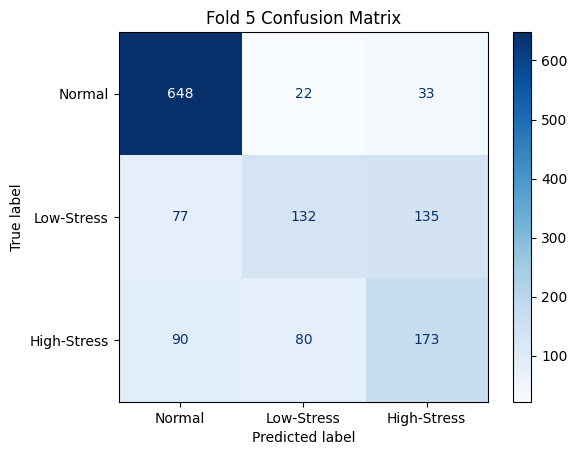

Sample Stress Scores: [np.float32(0.15721594), np.float32(0.11597453), np.float32(0.09075711), np.float32(0.41989362), np.float32(0.22996196), np.float32(0.05789476), np.float32(0.66272104), np.float32(0.05178398), np.float32(0.17598304), np.float32(0.622541)]
Saved ONNX model for fold 5: ./shallow_cnn_models/shallow_cnn_fold5.onnx

Mean K-Fold Accuracy: 0.6992 ± 0.0116


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy.signal import resample, butter, filtfilt, welch
import matplotlib.pyplot as plt
import torch.onnx

# ---- Reproducibility ----
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

# ---- Paths & Config ----
EEG_FOLDER = "/content/data_set/EEG"  # Change to your EEG path
HRV_FILE = "/content/data_set/HF/EO.xlsx"  # Change to your HRV file
TARGET_FS = 250
WINDOW_SEC = 4
OVERLAP_SEC = 2
BATCH_SIZE = 32
EPOCHS = 30
NUM_CLASSES = 3
MODEL_DIR = "./shallow_cnn_models"
os.makedirs(MODEL_DIR, exist_ok=True)

# ---- Signal Processing ----
def butter_bandpass_filter(data, lowcut=0.5, highcut=50, fs=250, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def extract_spectral_features(signal, fs):
    freqs, psd = welch(signal, fs=fs, nperseg=min(128,len(signal)//2))
    bands = [(0.5,4),(4,8),(8,13),(13,30),(30,50)]
    band_powers=[]
    total_power=np.trapz(psd,freqs)+1e-10
    for low, high in bands:
        idx=(freqs>=low)&(freqs<=high)
        power = np.trapz(psd[idx],freqs[idx]) if np.any(idx) else 0.0
        band_powers.append(power/total_power)
    return np.array(band_powers,dtype=np.float32)

def extract_time_features(signal):
    mean_val = np.mean(signal)
    std_val = np.std(signal)
    skew_val = np.mean((signal-mean_val)**3)/ (std_val**3 + 1e-10)
    kurt_val = np.mean((signal-mean_val)**4)/ (std_val**4 + 1e-10)
    p25 = np.percentile(signal,25)
    p75 = np.percentile(signal,75)
    sig_range = np.max(signal)-np.min(signal)
    rms_diff = np.sqrt(np.mean(np.diff(signal)**2)) if len(signal)>1 else 0
    return np.array([mean_val,std_val,skew_val,kurt_val,p25,p75,sig_range,rms_diff],dtype=np.float32)

def extract_hrv_features(hrv_value):
    feats = [hrv_value,np.log(hrv_value+1e-10),hrv_value**2,np.sqrt(hrv_value),
             1/(hrv_value+1e-10), np.sin(hrv_value*np.pi), np.cos(hrv_value*np.pi), np.tanh(hrv_value)]
    return np.array([f if np.isfinite(f) else 0.0 for f in feats],dtype=np.float32)

# ---- Data Loader ----
def load_eeg_hrv_data(eeg_folder, hrv_file):
    hrv_df=pd.read_excel(hrv_file)
    hrv_map=dict(zip(hrv_df["Subject NO."],hrv_df["HF Norm (a.u.)"]))
    condition_map={"EO":0,"AC1":1,"AC2":2}
    electrodes=["Fp1","Fp2"]
    all_data=[]
    for cond,label in condition_map.items():
        for elec in electrodes:
            file_path=os.path.join(eeg_folder,cond,f"{cond}_{elec}.csv")
            if not os.path.exists(file_path): continue
            df=pd.read_csv(file_path,header=None)
            for subj_id in range(1,df.shape[1]+1):
                if subj_id not in hrv_map: continue
                sig=df[subj_id-1].dropna().values
                if len(sig)<TARGET_FS*WINDOW_SEC: continue
                sig=resample(sig,int(len(sig)*TARGET_FS/2000))
                sig=butter_bandpass_filter(sig)
                sig=(sig-np.mean(sig))/(np.std(sig)+1e-10)
                win_len=WINDOW_SEC*TARGET_FS
                step_size=OVERLAP_SEC*TARGET_FS
                for start in range(0,len(sig)-win_len+1,step_size):
                    epoch=sig[start:start+win_len]
                    spectral_feats=extract_spectral_features(epoch,TARGET_FS)
                    time_feats=extract_time_features(epoch)
                    hrv_feats=extract_hrv_features(hrv_map[subj_id])
                    all_data.append({
                        "subject":subj_id,
                        "eeg":epoch.astype(np.float32),
                        "spectral":spectral_feats,
                        "time":time_feats,
                        "hrv":hrv_feats,
                        "label":label
                    })
    return all_data

# ---- Dataset ----
class StressDataset(Dataset):
    def __init__(self, samples, spectral_scaler=None, time_scaler=None, hrv_scaler=None, training=True):
        self.samples=samples
        spectral_feats=np.array([s["spectral"] for s in samples])
        time_feats=np.array([s["time"] for s in samples])
        hrv_feats=np.array([s["hrv"] for s in samples])
        self.spectral_scaler=spectral_scaler if spectral_scaler else StandardScaler().fit(spectral_feats)
        self.time_scaler=time_scaler if time_scaler else StandardScaler().fit(time_feats)
        self.hrv_scaler=hrv_scaler if hrv_scaler else StandardScaler().fit(hrv_feats)
        self.training = training
    def __len__(self): return len(self.samples)
    def __getitem__(self,idx):
        s=self.samples[idx]
        eeg = torch.tensor(s["eeg"],dtype=torch.float32).unsqueeze(0)
        spectral = torch.tensor(self.spectral_scaler.transform(s["spectral"].reshape(1,-1)).flatten(),dtype=torch.float32)
        time_feats = torch.tensor(self.time_scaler.transform(s["time"].reshape(1,-1)).flatten(),dtype=torch.float32)
        hrv = torch.tensor(self.hrv_scaler.transform(s["hrv"].reshape(1,-1)).flatten(),dtype=torch.float32)
        label = torch.tensor(s["label"],dtype=torch.long)
        return eeg, spectral, time_feats, hrv, label

# ---- Shallow CNN + Fusion ----
class ShallowEEGConvNet(nn.Module):
    def __init__(self,eeg_time_len,spectral_dim=5,time_dim=8,hrv_dim=8,conv_channels=[64,128],kernel_sizes=[11,7],dropout=0.35,num_classes=3):
        super().__init__()
        self.conv1=nn.Conv1d(1,conv_channels[0],kernel_size=kernel_sizes[0],padding=kernel_sizes[0]//2)
        self.bn1=nn.BatchNorm1d(conv_channels[0])
        self.conv2=nn.Conv1d(conv_channels[0],conv_channels[1],kernel_size=kernel_sizes[1],padding=kernel_sizes[1]//2)
        self.bn2=nn.BatchNorm1d(conv_channels[1])
        self.pool=nn.AdaptiveAvgPool1d(1)
        self.spectral_fc=nn.Sequential(nn.Linear(spectral_dim,32),nn.ReLU(),nn.Dropout(dropout))
        self.time_fc=nn.Sequential(nn.Linear(time_dim,32),nn.ReLU(),nn.Dropout(dropout))
        self.hrv_fc=nn.Sequential(nn.Linear(hrv_dim,32),nn.ReLU(),nn.Dropout(dropout))
        total=conv_channels[1]+32+32+32
        self.classifier=nn.Sequential(nn.Linear(total,128),nn.ReLU(),nn.Dropout(dropout),
                                      nn.Linear(128,64),nn.ReLU(),nn.Dropout(dropout),
                                      nn.Linear(64,num_classes))
    def forward(self,eeg,spectral,time_feats,hrv):
        x=F.relu(self.bn1(self.conv1(eeg)))
        x=F.relu(self.bn2(self.conv2(x)))
        x=self.pool(x).squeeze(-1)
        spec=self.spectral_fc(spectral)
        t=self.time_fc(time_feats)
        h=self.hrv_fc(hrv)
        fused=torch.cat([x,spec,t,h],dim=1)
        logits=self.classifier(fused)
        probs=F.softmax(logits,dim=1)
        stress_score=probs[:,1]*0.5+probs[:,2]*1.0
        return logits, probs, stress_score

# ---- Train & Evaluate K-Fold + ONNX ----
def train_eval_kfold_onnx(all_data,device='cpu',n_splits=5):
    X = np.arange(len(all_data))
    y = np.array([s['label'] for s in all_data])
    skf = StratifiedKFold(n_splits=n_splits,shuffle=True,random_state=SEED)
    fold_idx=0
    all_fold_acc=[]
    os.makedirs(MODEL_DIR, exist_ok=True)

    for train_idx,test_idx in skf.split(X,y):
        fold_idx+=1
        train_samples=[all_data[i] for i in train_idx]
        test_samples=[all_data[i] for i in test_idx]
        train_loader=DataLoader(StressDataset(train_samples,training=True),batch_size=BATCH_SIZE,shuffle=True)
        test_loader=DataLoader(StressDataset(test_samples,training=False),batch_size=BATCH_SIZE,shuffle=False)
        eeg_len=train_samples[0]['eeg'].shape[0]
        model=ShallowEEGConvNet(eeg_time_len=eeg_len).to(device)
        optimizer=torch.optim.AdamW(model.parameters(),lr=1e-3,weight_decay=1e-4)
        scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=EPOCHS)
        criterion=nn.CrossEntropyLoss()
        best_acc=0.0

        # Train
        for epoch in range(EPOCHS):
            model.train()
            for eeg,spec,time_feats,hrv,labels in train_loader:
                eeg,spec,time_feats,hrv,labels = eeg.to(device),spec.to(device),time_feats.to(device),hrv.to(device),labels.to(device)
                optimizer.zero_grad()
                logits,_,_ = model(eeg,spec,time_feats,hrv)
                loss = criterion(logits,labels)
                loss.backward()
                optimizer.step()
            scheduler.step()

        # Validation
        model.eval()
        all_preds, all_labels, all_scores = [],[],[]
        with torch.no_grad():
            for eeg,spec,time_feats,hrv,labels in test_loader:
                eeg,spec,time_feats,hrv,labels = eeg.to(device),spec.to(device),time_feats.to(device),hrv.to(device),labels.to(device)
                logits,probs,stress_score = model(eeg,spec,time_feats,hrv)
                preds = torch.argmax(probs,dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_scores.extend(stress_score.cpu().numpy())

        acc = accuracy_score(all_labels,all_preds)
        all_fold_acc.append(acc)
        print(f"\nFold {fold_idx} | Accuracy: {acc:.4f}")
        print(classification_report(all_labels,all_preds,target_names=["Normal","Low-Stress","High-Stress"]))
        cm=confusion_matrix(all_labels,all_preds)
        ConfusionMatrixDisplay(cm,display_labels=["Normal","Low-Stress","High-Stress"]).plot(cmap=plt.cm.Blues)
        plt.title(f"Fold {fold_idx} Confusion Matrix")
        plt.show()
        print("Sample Stress Scores:", all_scores[:10])

        # ---- Save Model in ONNX ----
        onnx_path = os.path.join(MODEL_DIR,f"shallow_cnn_fold{fold_idx}.onnx")
        dummy_eeg = torch.randn(1,1,eeg_len).to(device)
        dummy_spec = torch.randn(1,5).to(device)
        dummy_time = torch.randn(1,8).to(device)
        dummy_hrv = torch.randn(1,8).to(device)
        try:
            torch.onnx.export(model,
                              (dummy_eeg,dummy_spec,dummy_time,dummy_hrv),
                              onnx_path,
                              input_names=['eeg_input','spectral_input','time_input','hrv_input'],
                              output_names=['logits'],
                              dynamic_axes={'eeg_input': {0: 'batch_size'},
                                            'spectral_input': {0: 'batch_size'},
                                            'time_input': {0: 'batch_size'},
                                            'hrv_input': {0: 'batch_size'},
                                            'logits': {0: 'batch_size'}},
                              opset_version=11)
            print(f"Saved ONNX model for fold {fold_idx}: {onnx_path}")
        except Exception as e:
            print(f"ONNX export failed for fold {fold_idx}: {e}")

    print(f"\nMean K-Fold Accuracy: {np.mean(all_fold_acc):.4f} ± {np.std(all_fold_acc):.4f}")

# ---- Main ----
if __name__=="__main__":
    all_data_list = load_eeg_hrv_data(EEG_FOLDER,HRV_FILE)
    if not all_data_list: print("No data loaded!"); exit()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_eval_kfold_onnx(all_data_list,device)


In [ ]:
!zip -r out.zip /content/shallow_cnn_models

  adding: content/shallow_cnn_models/ (stored 0%)
  adding: content/shallow_cnn_models/shallow_cnn_fold3.onnx (deflated 8%)
  adding: content/shallow_cnn_models/shallow_cnn_fold4.onnx (deflated 8%)
  adding: content/shallow_cnn_models/shallow_cnn_fold5.onnx (deflated 8%)
  adding: content/shallow_cnn_models/shallow_cnn_fold1.onnx (deflated 8%)
  adding: content/shallow_cnn_models/shallow_cnn_fold2.onnx (deflated 8%)
